In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6,7"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"
import torch
from sema_guidance_v1 import StableDiffusionFreeGuidancePipeline
# from sema_guidance import StableDiffusionFreeGuidancePipeline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from tqdm.auto import tqdm
from torch.nn import init
from utils.guidance_functions import *
import argparse
from diffusers import LMSDiscreteScheduler, DDPMScheduler, DDIMScheduler, DPMSolverMultistepScheduler
from utils import *
from PIL import Image
torch.cuda.manual_seed_all(1234) 
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['image.cmap'] = 'gray_r'


/root/anaconda3/envs/free_guide/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

print("Start Inference!")
model_id = "runwayml/stable-diffusion-v1-5"
device = "cuda"
NUM_DDIM_STEPS = 50
pipe = StableDiffusionFreeGuidancePipeline.from_pretrained(model_id, torch_dtype=torch.float16, variant="fp16")
pipe.unet = UNetDistributedDataParallel(pipe.unet, device_ids=[0]).cuda()
# pipe.vae = UNetDistributedDataParallel(pipe.vae, device_ids=[0,1,2]).cuda()
# pipe.text_encoder = UNetDistributedDataParallel(pipe.text_encoder, device_ids=[0,1,2]).cuda()
# pipe.unet = pipe.unet.to(device)
# pipe.text_encoder = UNetDistributedDataParallel(pipe.text_encoder, device_ids=[0,1,2,3,4], output_device=3).cuda()
# pipe.unet.config, pipe.unet.dtype, pipe.unet.attn_processors, pipe.unet.set_attn_processor = pipe.unet.module.config, pipe.unet.module.dtype, pipe.unet.module.attn_processors, pipe.unet.module.set_attn_processor
# pipe.unet.config, pipe.unet.dtype = pipe.unet.module.config, pipe.unet.module.dtype
pipe.unet = pipe.unet.module
pipe = pipe.to(device)

# pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config) # DDPMScheduler -> DDIMScheduler
pipe.scheduler.set_timesteps(NUM_DDIM_STEPS)

pipe.enable_attention_slicing()
torch.backends.cudnn.benchmark = True

Start Inference!


Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


Model loaded successfully!


cross_attention dimension
down_blocks：
4096 4096
1024 1024
256 256
mid：
64
up_block：
256 256 256
1024 1024 1024
4096 4096 4096
res activation
down_blocks：
layer1 (1,320,64,64)
layer2 (1,640,32,32)
layer3 (1,1280,16,16)
layer4 (1,1280,8,8)
up_block：
layer1 (1,1280,8,8)
layer2 (1,1280,16,16)
layer3 (1,640,32,32)
layer4 (1,320,64,64)

73765


100%|██████████| 50/50 [08:30<00:00, 10.22s/it]


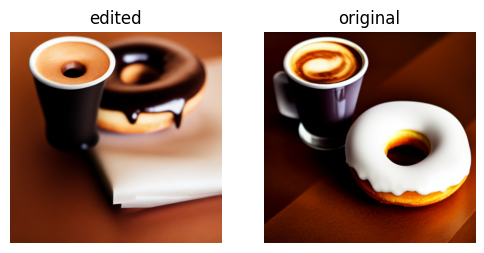

In [ ]:
seed = int(torch.rand((1,)) * 100000)
generator=torch.manual_seed(seed)
print(seed)

prompt = 'a photo of a donut and a shot of espresso on a table'
object_to_edit = 'donut'
objects = ['donut', 'espresso']
move = partial(roll_shape, direction='up', factor=0.4)
guidance = partial(move_object_by_shape, shape_weight=0.5, appearance_weight=1.5, position_weight=6, tau=move)

img_path = './img/donut.png'
latents = get_ddim_latents(pipe, img_path, prompt, device)
init_latents = latents[-1]
# init_latents = get_latents_from_image(pipe, img_path, device)

image_list = pipe(prompt, obj_to_edit = object_to_edit, height=512, width=512, 
                  num_inference_steps=50, generator=generator, latents=init_latents, all_latents=latents,
                  max_guidance_iter_per_step=15, guidance_func=guidance, g_weight=3000)
show_images([i for i in [image_list[0].images[0], image_list[1].images[0]]], titles=['edited', 'original'], save_orig=True)

In [3]:
seed = int(torch.rand((1,)) * 100000)
generator=torch.manual_seed(seed)
print(seed)

# make controller
prompts = ["a photo of a dog", 
           "a photo of a cat"]

cross_replace_steps = {'default_':.8,}
self_replace_steps = .5 
blend_word = ((('dog',), ('cat',)))
eq_params = {"words": ('cat',), "values": (2,)}

attention_controller = make_controller(prompts, True, cross_replace_steps, self_replace_steps, NUM_DDIM_STEPS, pipe.tokenizer, device, blend_word, eq_params)

# give guidance to latent
prompt = 'a photo of a dog'
object_to_edit = 'dog'
guidance = partial(edit_layout_by_feature, appearance_weight=1.5)

img_path = './img/dog.png'
latents = get_ddim_latents(pipe, img_path, prompt, device)
init_latent = latents[-1]

image_list = pipe(prompt, obj_to_edit = object_to_edit, height=512, width=512, 
                  num_inference_steps=50, generator=generator, latents=init_latent, all_latents=latents, attention_controller=attention_controller,
                  max_guidance_iter_per_step=15, guidance_func=guidance, g_weight=500)
show_images([i for i in [image_list[0].images[0], image_list[1].images[0]]], titles=['edited', 'original'], save_orig=True)

54991


  0%|          | 0/50 [00:00<?, ?it/s]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') ten

  2%|▏         | 1/50 [00:51<42:05, 51.55s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') ten

  4%|▍         | 2/50 [00:57<19:51, 24.83s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') ten

  6%|▌         | 3/50 [01:03<12:44, 16.26s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') te

  8%|▊         | 4/50 [01:08<08:52, 11.59s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') 

 10%|█         | 5/50 [01:12<06:44,  9.00s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') 

 12%|█▏        | 6/50 [01:16<05:23,  7.35s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') ten

 14%|█▍        | 7/50 [01:21<04:40,  6.52s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') ten

 16%|█▌        | 8/50 [01:27<04:19,  6.19s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') te

 18%|█▊        | 9/50 [01:31<03:57,  5.80s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') 

 20%|██        | 10/50 [01:36<03:34,  5.37s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') 

 22%|██▏       | 11/50 [01:40<03:16,  5.03s/it]

tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.S

 24%|██▍       | 12/50 [01:44<03:01,  4.78s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') te

 26%|██▌       | 13/50 [01:49<02:58,  4.81s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') ten

 28%|██▊       | 14/50 [01:56<03:12,  5.34s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') ten

 30%|███       | 15/50 [02:01<03:06,  5.33s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') ten

 32%|███▏      | 16/50 [02:07<03:07,  5.50s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') 

 34%|███▍      | 17/50 [02:13<03:06,  5.65s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') 

 36%|███▌      | 18/50 [02:18<02:50,  5.32s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') ten

 38%|███▊      | 19/50 [02:23<02:44,  5.32s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') ten

 40%|████      | 20/50 [02:29<02:44,  5.49s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') ten

 42%|████▏     | 21/50 [02:34<02:36,  5.39s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') ten

 44%|████▍     | 22/50 [02:40<02:35,  5.56s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') ten

 46%|████▌     | 23/50 [02:45<02:26,  5.41s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') ten

 48%|████▊     | 24/50 [02:51<02:25,  5.60s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') ten

 50%|█████     | 25/50 [02:56<02:16,  5.48s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') ten

 52%|█████▏    | 26/50 [03:02<02:15,  5.65s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') ten

 54%|█████▍    | 27/50 [03:08<02:11,  5.71s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') ten

 56%|█████▌    | 28/50 [03:13<01:59,  5.43s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') ten

 58%|█████▊    | 29/50 [03:18<01:52,  5.34s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') ten

 60%|██████    | 30/50 [03:24<01:51,  5.55s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') ten

 62%|██████▏   | 31/50 [03:29<01:42,  5.42s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') ten

 64%|██████▍   | 32/50 [03:35<01:40,  5.61s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') t

 66%|██████▌   | 33/50 [03:40<01:32,  5.42s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') ten

 68%|██████▊   | 34/50 [03:46<01:29,  5.57s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') 

 70%|███████   | 35/50 [03:52<01:26,  5.75s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') ten

 72%|███████▏  | 36/50 [03:59<01:22,  5.92s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') ten

 74%|███████▍  | 37/50 [04:04<01:15,  5.82s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') t

 76%|███████▌  | 38/50 [04:10<01:11,  5.93s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') ten

 78%|███████▊  | 39/50 [04:15<01:01,  5.56s/it]

tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
tor

 80%|████████  | 40/50 [04:21<00:56,  5.68s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') ten

 82%|████████▏ | 41/50 [04:26<00:49,  5.52s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') ten

 84%|████████▍ | 42/50 [04:32<00:44,  5.60s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') te

 86%|████████▌ | 43/50 [04:37<00:38,  5.45s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') te

 88%|████████▊ | 44/50 [04:44<00:35,  5.85s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') t

 90%|█████████ | 45/50 [04:50<00:29,  5.92s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') 

 92%|█████████▏| 46/50 [04:56<00:24,  6.04s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') t

 94%|█████████▍| 47/50 [05:02<00:17,  5.92s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') 

 96%|█████████▌| 48/50 [05:08<00:12,  6.07s/it]

masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])
masks shape:  torch.Size([2, 1, 64, 64]) torch.Size([2, 1, 64, 64])
masks min max values:  tensor(True, device='cuda:0') tensor(True, device='cuda:0') tensor(False, device='cuda:0') tensor(True, device='cuda:0')
torch.Size([1, 4, 64, 64]) torch.Size([1, 1, 64, 64]) torch.Size([1, 4, 64, 64])


## Swapping word

In [ ]:
def make_controller(prompts: List[str], is_replace_controller: bool, cross_replace_steps: Dict[str, float], self_replace_steps: float, blend_words=None, equilizer_params=None) -> AttentionControlEdit:
    if blend_words is None:
        lb = None
    else:
        lb = LocalBlend(prompts, blend_word)
    if is_replace_controller:
        controller = AttentionReplace(prompts, NUM_DDIM_STEPS, cross_replace_steps=cross_replace_steps, self_replace_steps=self_replace_steps, local_blend=lb)
    else:
        controller = AttentionRefine(prompts, NUM_DDIM_STEPS, cross_replace_steps=cross_replace_steps, self_replace_steps=self_replace_steps, local_blend=lb)
    if equilizer_params is not None:
        eq = get_equalizer(prompts[1], equilizer_params["words"], equilizer_params["values"])
        controller = AttentionReweight(prompts, NUM_DDIM_STEPS, cross_replace_steps=cross_replace_steps,
                                       self_replace_steps=self_replace_steps, equalizer=eq, local_blend=lb, controller=controller)
    return controller

def run_and_display(prompts, controller, latent=None, run_baseline=False, generator=None, uncond_embeddings=None, verbose=True):
    if run_baseline:
        print("w.o. prompt-to-prompt")
        images, latent = run_and_display(prompts, EmptyControl(), latent=latent, run_baseline=False, generator=generator)
        print("with prompt-to-prompt")
    images, x_t = text2image_ldm_stable(ldm_stable, prompts, controller, latent=latent, num_inference_steps=NUM_DDIM_STEPS, guidance_scale=GUIDANCE_SCALE, generator=generator, uncond_embeddings=uncond_embeddings)
    if verbose:
        ptp_utils.view_images(images)
    return images, x_t

In [ ]:
prompts = ['a photo of a dog',
           'a photo of a cat'
        ]

cross_replace_steps = {'default_': .8,}
self_replace_steps = .5
blend_word = ((('dog',), ('cat', )))
eq_params = {"words": ("cat",), "values": (2,)}

controller = make_controller(prompts, True, cross_replace_steps, self_replace_steps, blend_word, eq_params)
images, _ = run_and_display(prompts, controller, run_baseline=False, latent=x_t, uncond_embeddings=uncond_embeddings)

print("Image is highly affected by the self_replace_steps, usually 0.4 is a good default value, but you may want to try the range 0.3,0.4,0.5,0.7 ")